In [2]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

### datasets.py

**Classe Dataset:**
- introduir una classe per al nou dataset que pugui manejar imatges 2D i les seves corresponents anotacions
- PyTorch té una classe anomenada CocoDetection a `torchvision.datasets`
- crear una classe a partir de CocoDetection amb les anotacions utilitzades en el `train.py`

**Transformacions que hauré de dur a terme (potser):**
- Adaptar la data augmentation i el preprocessing per a imatges 2D
- resize, normalitzar amb les means i sd de COCO
- data augmentation, flipping, random cropping...

**Annotation Processing:**
- Incorporar la lògica per manejar les anotacions de COCO
- ...

In [2]:
# prova amb CocoDetection
from torchvision.datasets import CocoDetection
import torchvision.transforms as transforms

class COCODataset(CocoDetection):
    def __init__(self, root, annFile, transform=None):
        super(COCODataset, self).__init__(root, annFile, transform=transform)
        # mirar si he d'inicialitzar cap més paràmetre

    def __getitem__(self, index):
        img, target = super(COCODataset, self).__getitem__(index)

        return img, target


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

coco_dataset = COCODataset(root='datafile/coco/train2017/images', annFile='datafile/coco/train2017/instances_train2017.json', transform=transform)

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: 'datafile/coco/train2017/instances_train2017.json'

## train.py

**Data Loader:**
- substituir quan cridem *load_data_volume* amb un mecanisme que inicialitzi la classe del dataset de COCO
- especificar el path a les imatges i a les anotacions. *(datafile/coco/train2017/)*
- potser fer data augmentation (mirar més endavant)

**Ajustar el model:**
- de manera fàcil: passar d'un model que llegeix volums 3D a un que pugui llegir models 2D.
- Assegurar que la input layer del model pugui llegir 2D images.
- Adaptar l'arquitectura per tal que accepti imatges en tres canals RGB (assumint que les imatges de COCO siguin vectors RGB)

**Batch Processing:**
- Ajustar el codi per tal que cada batch pugui treballar en 2D
- Les operacions spatial o les feature extractions que són específiques per a imatges 3D s'han de canviar.

**Loss functions i mètriques:**
- mirar que les loss functions i les mètriques siguin apropiades per a la segmentació / detecció d'objectes del COCO dataset.

Script per descarregar les annotations del dataset de COCO

In [11]:
import zipfile
import requests

def download_file(url, target_path):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    with open(target_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

annotations_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
annotations_zip_path = "coco_data/annotations_trainval2017.zip"
download_file(annotations_url, annotations_zip_path)

with zipfile.ZipFile(annotations_zip_path, 'r') as zip_ref:
    zip_ref.extractall("./coco_data")

Script per descarregar subset d'imatges de COCO a partir del .json

In [44]:
from pycocotools.coco import COCO
import requests
import os

dataDir = 'coco_data'
dataType = 'val2017'
annFile = f'{dataDir}/annotations/instances_{dataType}.json'
coco = COCO(annFile)
valDir = f'{dataDir}/{dataType}'
if not os.path.exists(valDir):
    os.makedirs(valDir)

categories = ['cat', 'dog'] # provem amb gossos i gats
catIds = coco.getCatIds(catNms=categories)
imgIds = coco.getImgIds(catIds=catIds)
imgIds = imgIds[:3]  # canviar
images = coco.loadImgs(imgIds)

for img in images:
    img_url = f'http://images.cocodataset.org/{dataType}/{img["file_name"]}'
    img_path = f'{dataDir}/{dataType}/{img["file_name"]}'
    if not os.path.exists(img_path):
        with requests.get(img_url) as r:
            r.raise_for_status()
            with open(img_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
    print(f'Downloaded {img_path}')

loading annotations into memory...
Done (t=1.39s)
creating index...
index created!
Downloaded coco_data/val2017/000000179392.jpg
Downloaded coco_data/val2017/000000401991.jpg
Downloaded coco_data/val2017/000000022892.jpg


In [47]:
print(imgIds)

[179392]


loading annotations into memory...
Done (t=1.46s)
creating index...
index created!
Downloaded image coco_data/val2017/000000179392.jpg


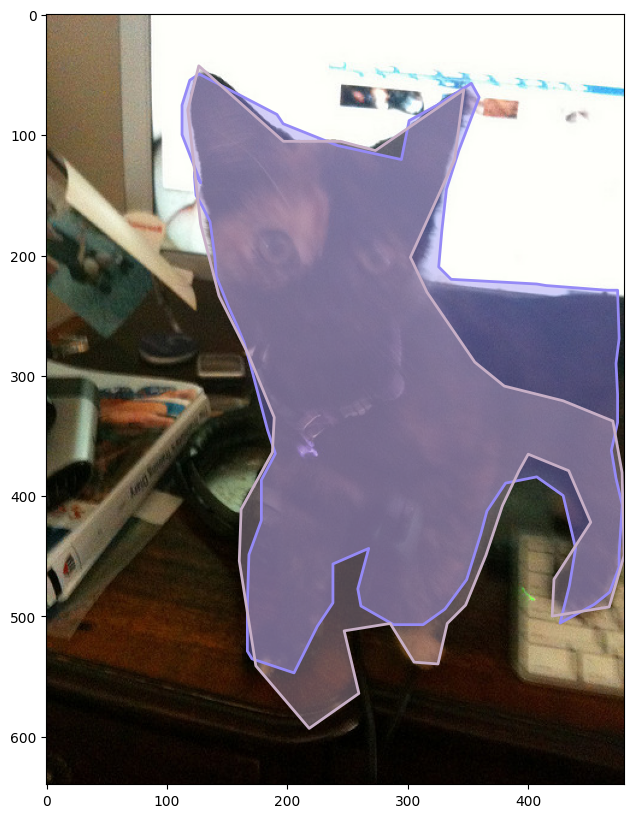

In [46]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os
import requests

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

dataDir = 'coco_data'
dataType = 'val2017'
annFile = f'{dataDir}/annotations/instances_{dataType}.json'
coco = COCO(annFile)

valDir = f'{dataDir}/{dataType}'
if not os.path.exists(valDir):
    os.makedirs(valDir)

categories = ['cat', 'dog']
catIds = coco.getCatIds(catNms=categories)
imgIds = coco.getImgIds(catIds=catIds)
imgIds = imgIds[:1]  # Limita a 1 imatge
images = coco.loadImgs(imgIds)

# imatges i labels
for img in images:
    img_url = f'http://images.cocodataset.org/{dataType}/{img["file_name"]}' #descarregar imatges
    img_path = f'{dataDir}/{dataType}/{img["file_name"]}' #path
    if not os.path.exists(img_path):
        with requests.get(img_url) as r:
            r.raise_for_status()
            with open(img_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
    print(f'Downloaded image {img_path}')

    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)

    plt.imshow(io.imread(img_url))
    coco.showAnns(anns) # màscares de segmentació
    plt.show()


Visualitzar imatge

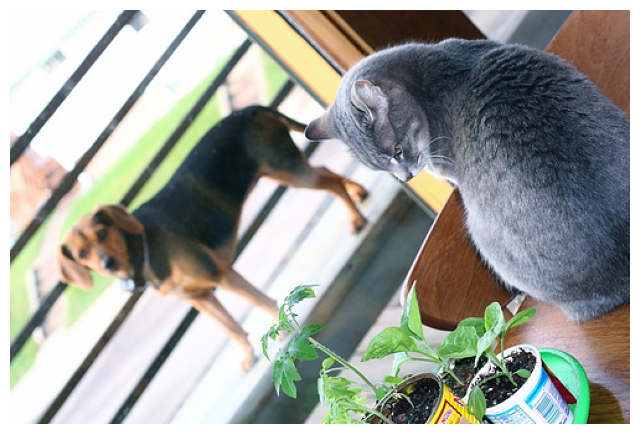

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

# Assuming you've downloaded an image to 'path/to/image.jpg'
image_path = 'coco_data/val2017/000000022892.jpg'
img = Image.open(image_path)

plt.imshow(img)
plt.axis('off')
plt.show()

Visualitzar les imatges del dataset mining de les imatges del dataset del paper:

In [17]:
import nibabel as nib
labelTr_colon = nib.load('../datafile/Task10_Colon/labelsTr/colon_212.nii.gz')
print(labelTr_colon.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 729   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.       0.765625 0.765625 1.25     0.       0.       0.       0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -211.53438
qoffset_y       : -195.23438
qoffset

In [ ]:
import nibabel as nib

imTr_colon = nib.load('../datafile/Task10_Colon/imagesTr/colon_005.nii.gz')
plt.imshow(imTr_colon.get_fdata()[:,:,20])
print(imTr_colon.header)

# Transformació del COCO de 2D a 3D .nii
(ho fem per una imatge després fer la implementació per a un conjunt d'imatges)

## 1. Creació de volums 3D a partir d'imatges 2D:
Una aproximació seria replicar l'imatge 2D múltiples vegades per crear un volum 3D. Aquesta tècnica, però, no afegeix informació tridimensional real a les imatges, però pot servir per compatibilitat amb l'entrada esperada pel model 3D SAM Adapter. També, per tal de tenir un volum més petit controlat podem encabir aquesta part entre n matrius de zeros.

## 2. Preparació de ground trruths:
En cas que les imatges de COCO vinguin amb anotacions de segmentació (per exemple, màscares de segmentació per gossos i gats), aquestes màscares es podrien convertir també en volums 3D seguint el mateix procediment que per les imatges. Això implicaria crear una màscara 3D per cada imatge 2D replicant la màscara de segmentació 2D a través de la tercera dimensió.

## 3. Fitxer split.pkl:
El fitxer conté informació sobre la partició del dataset en conjunts de train/test/validation. Assignar les imatges COCO transformades als conjunts adequats per a entrenament o validació.

## 4. Altres coses:
Ajustar el preprocessament aplicat a les dades originals de tumors per assegurar-se que les imatges COCO transformades siguin processades de manera consistent. Això podria incloure l'ajust del rang d'intensitat, la normalització, etc.

In [54]:
from pycocotools.coco import COCO
import numpy as np
import nibabel as nib
import cv2

"""
Pas 0: Descarregar imatges de la COCO
"""
# fet a dalt hem descarregat 3 imatges

"""
PAS 1: Creació dels volums 3D a partir d'imatges de la COCO 2D
"""

folder_path = 'coco_data/val2017'
imgs_path = list()
for img in os.listdir(folder_path):
    imgs_path.append(f'{folder_path}/{img}')

img_2d = cv2.imread(imgs_path[0], cv2.IMREAD_UNCHANGED) # fem per una sola imatge
img_2d = cv2.resize(img_2d, (img_2d.shape[1] // 2, img_2d.shape[0] // 2)) #reducció de resolució (sinó volums molt grans)

if len(img_2d.shape) == 3:
    img_2d = cv2.cvtColor(img_2d, cv2.COLOR_BGR2GRAY)

depth = 20
zeros_depth = 25

img_3d = np.repeat(img_2d[:, :, np.newaxis], depth, axis=2)

zeros_top = np.zeros((img_2d.shape[0], img_2d.shape[1], zeros_depth))
zeros_bottom = np.zeros((img_2d.shape[0], img_2d.shape[1], zeros_depth))

final_volume = np.concatenate((zeros_top, img_3d, zeros_bottom), axis=2)

new_image = nib.Nifti1Image(final_volume, affine=np.eye(4))
output_path = 'coco_data/val2017/000000179392_3d.nii.gz' # output file
nib.save(new_image, output_path)

print(f"Volum 3D guardat com: {output_path}")

Volum 3D guardat com: coco_data/val2017/000000179392_3d.nii.gz


In [56]:
"""
PAS 2: generar les màsqueres de segmentació 2D de la COCO
"""
filename = '000000022892.jpg'
dataDir = 'coco_data'
dataType = 'val2017'
annFile = f'{dataDir}/annotations/instances_{dataType}.json'
coco = COCO(annFile)

img_id = 179392 # procedent de quan fem la descàrrega (fer per a moltes imatges)
img_info = coco.loadImgs(img_id)[0]
img_path = f'{dataDir}/{dataType}/{img_info["file_name"]}'
img = cv2.imread(img_path)

annIds = coco.getAnnIds(imgIds=img_info['id'], iscrowd=None)
anns = coco.loadAnns(annIds)

# crear una màscara per a cada anotació i fusionar-les (potser només agafar una label,mirar)
mask_total = np.zeros((img_info['height'], img_info['width']))
for ann in anns:
    mask = coco.annToMask(ann)
    mask_total = np.maximum(mask_total, mask) # fusio

mask_path = img_path.replace('.jpg', '_mask.png')
cv2.imwrite(mask_path, mask_total * 255)

"""
PAS 3: convertir la màscara 2D a volum 3D .nii
"""
mask_3d = np.repeat(mask_total[:, :, np.newaxis], depth, axis=2)
zeros_top = np.zeros((mask_total.shape[0], mask_total.shape[1], zeros_depth))
zeros_bottom = np.zeros((mask_total.shape[0], mask_total.shape[1], zeros_depth))

final_volume_mask = np.concatenate((zeros_top, mask_3d, zeros_bottom), axis=2)

new_image_mask = nib.Nifti1Image(final_volume_mask, affine=np.eye(4))
nib.save(new_image_mask, mask_path.replace('.png', '_3d.nii.gz'))

loading annotations into memory...
Done (t=1.47s)
creating index...
index created!


## TOT EL PROCÉS: descàrrega, creació de volum, creació de volum per a la màscara segmentada i emmagatzemar-los en format .nii.gz

In [ ]:
from pycocotools.coco import COCO
import requests
import numpy as np
import nibabel as nib
import cv2
import os

dataDir = 'coco_data'
dataType = 'val2017'
annFile = os.path.join(dataDir, 'annotations', f'instances_{dataType}.json')
num_imgs = 5  # nombre d'imatges que volem convertir

img_output_dir = os.path.join(dataDir, dataType, 'imagesTr')
mask_output_dir = os.path.join(dataDir, dataType, 'labelsTr')

os.makedirs(img_output_dir, exist_ok=True)
os.makedirs(mask_output_dir, exist_ok=True)

coco = COCO(annFile)

# ids gossos i gats
categories = ['cat', 'dog']
catIds = coco.getCatIds(catNms=categories)
imgIds = coco.getImgIds(catIds=catIds)[:num_imgs]  # limitar a num_imgs
images = coco.loadImgs(imgIds)

for img in images:
    img_url = f'http://images.cocodataset.org/{dataType}/{img["file_name"]}'
    img_path = os.path.join(dataDir, dataType, img["file_name"])
    if not os.path.exists(img_path):
        with requests.get(img_url) as r:
            r.raise_for_status()
            with open(img_path, 'wb') as f:
                f.write(r.content)
    print(f'Downloaded {img_path}')

    # Carregar i processar imatge
    original_img = cv2.imread(img_path)
    if original_img is None:
        raise ValueError("Error loading image")

    img_2d = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    img_2d = cv2.resize(img_2d, (512, 512))  # resolució

    depth = 20
    zeros_depth = 25
    img_3d = np.repeat(img_2d[:, :, np.newaxis], depth, axis=2)
    zeros_layer = np.zeros((512, 512, zeros_depth))
    final_volume = np.concatenate((zeros_layer, img_3d, zeros_layer), axis=2)
    new_image = nib.Nifti1Image(final_volume, affine=np.eye(4))

    output_path = os.path.join(img_output_dir, img["file_name"].replace('.jpg', '_3d.nii.gz'))
    nib.save(new_image, output_path)
    print(f"Volum 3D: {output_path}")

    # Processar i guardar màscara 3D
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    mask_total = np.zeros((512, 512))  # mateixa resolució
    for ann in anns:
        mask = coco.annToMask(ann)
        mask = cv2.resize(mask, (512, 512))  # resolució
        mask_total = np.maximum(mask_total, mask)

    mask_3d = np.repeat(mask_total[:, :, np.newaxis], depth, axis=2)
    final_volume_mask = np.concatenate((zeros_layer, mask_3d, zeros_layer), axis=2)
    new_image_mask = nib.Nifti1Image(final_volume_mask, affine=np.eye(4))
    mask_output_path = os.path.join(mask_output_dir, img["file_name"].replace('.jpg', '_3d.nii.gz'))
    nib.save(new_image_mask, mask_output_path)
    print(f"Màscara 3D: {mask_output_path}")
